# Klassifikaiton
**Teori** - [**Notion Klassifikation**](https://www.notion.so/mercantec/Machine-Learning-e89a2baf0d414172b13d07465366482e?pvs=4#1a2aef001e294c9bb2354f79b3db80d3)

# Billedklassifikation
Denne vejledning viser, hvordan man klassificerer billeder af blomster ved hjælp af en `tf.keras.Sequential` model og indlæser data ved hjælp af `tf.keras.utils.image_dataset_from_directory`. Den demonstrerer følgende koncepter:

- Effektiv indlæsning af et dataset fra disken.
- Identifikation af overfitting og anvendelse af teknikker til at mindske det, herunder dataaugmentering og dropout.

Denne vejledning følger en grundlæggende maskinlæringsarbejdsgang:

1. **Undersøg og forstå data**
2. **Byg en input-pipelining**
3. **Opret modellen**
4. **Træn modellen**
5. **Test modellen**
6. **Forbedr modellen og gentag processen**

Derudover demonstrerer notebooken, hvordan man konverterer en [gemt model](../../../guide/saved_model.ipynb) til en [TensorFlow Lite](https://www.tensorflow.org/lite/) model til maskinlæring på mobile, integrerede og IoT-enheder.


## Opsætning

Importer TensorFlow og andre nødvendige biblioteker:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Hent og udforsk datasættet

Denne vejledning bruger et datasæt med cirka 3.700 fotos af blomster. Datasættet indeholder fem undermapper, en pr. klasse:
```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```


In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 13s 0us/step


Efter download bør du nu have en kopi af datasættet tilgængelig. Der er i alt 3.670 billeder:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Her er nogle roser:

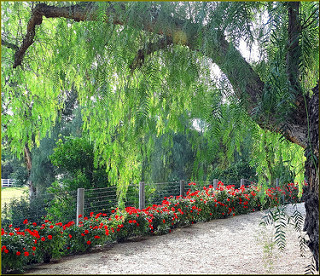

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

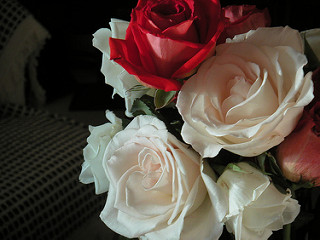

In [8]:
PIL.Image.open(str(roses[1]))

Og nogle tulipaner:

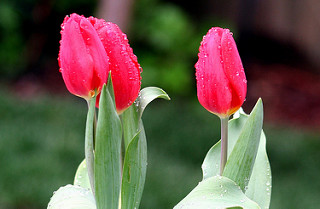

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

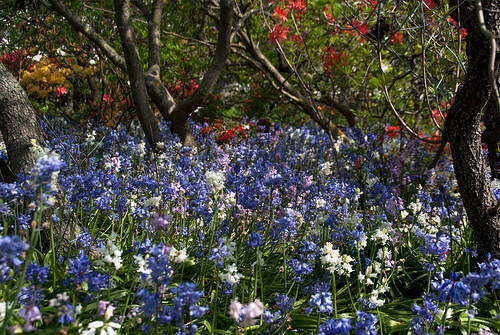

In [10]:
PIL.Image.open(str(tulips[1]))

## Indlæs data ved hjælp af et Keras-værktøj

Dernæst kan du indlæse disse billeder fra disken ved hjælp af den nyttige `tf.keras.utils.image_dataset_from_directory`-funktion. Dette vil tage dig fra en mappe med billeder på disken til en `tf.data.Dataset` med blot et par linjer kode. 


### Opret en datasæt
Definér nogle parametre for indlæseren:


In [11]:
batch_size = 32
img_height = 180
img_width = 180

Det er god praksis at bruge en valideringssplit, når du udvikler din model. Brug 80% af billederne til træning og 20% til validering.


In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Du kan finde klassenavne i `class_names` attributten på disse datasæt. Disse svarer til mappenavne i alfabetisk rækkefølge.

In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualiser dataen

Her er de første ni billeder fra træningsdatasættet:

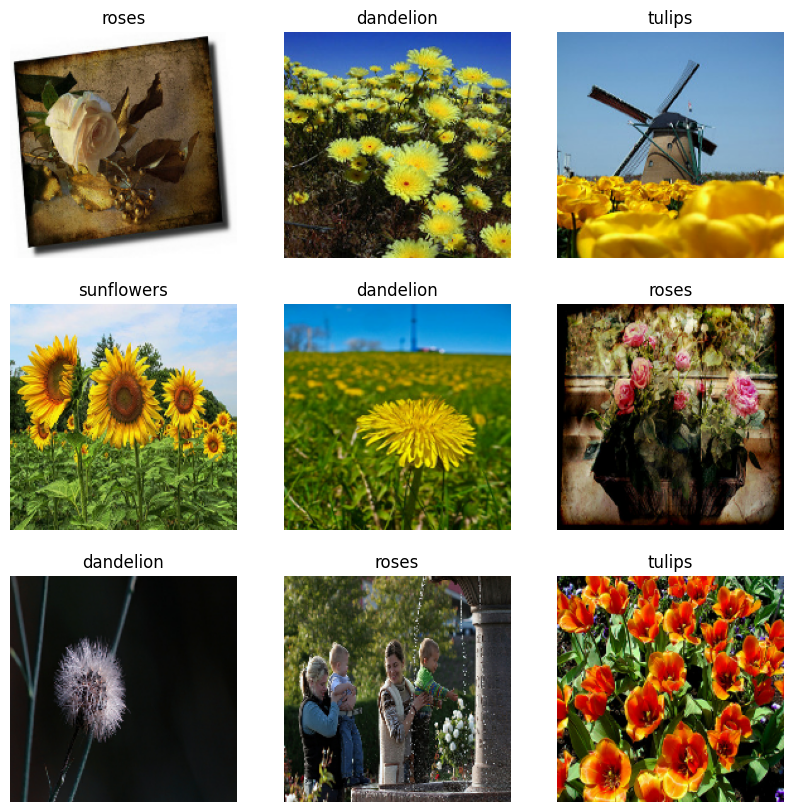

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Senere i denne vejledning vil du overføre disse datasæt til Keras `Model.fit`-metoden til træning. Hvis du foretrækker det, kan du også manuelt iterere over datasættet og hente batcher af billeder:

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch` er en tensor med formen `(32, 180, 180, 3)`. Dette er en batch med 32 billeder med formen `180x180x3` (den sidste dimension refererer til farvekanalerne RGB). `label_batch` er en tensor med formen `(32,)`, og det er de tilhørende etiketter til de 32 billeder.

Du kan bruge `.numpy()` på `image_batch` og `label_batch` tensorerne for at konvertere dem til en `numpy.ndarray`.


## Konfigurer datasættet for bedre ydeevne

Sørg for at bruge bufferlagring (buffered prefetching), så du kan hente data fra disken uden at I/O bliver blokerende. Her er to vigtige metoder, du bør bruge, når du indlæser data:

- `Dataset.cache` gemmer billederne i hukommelsen efter de er blevet indlæst fra disken under den første epoke. Dette vil sikre, at datasættet ikke bliver en flaskehals under træningen af din model. Hvis dit datasæt er for stort til at passe i hukommelsen, kan du også bruge denne metode til at oprette en ydeevnedrevet cache på disken.
- `Dataset.prefetch` overlapper dataforarbejdning og modelkørsel under træning.

Interesserede læsere kan lære mere om begge metoder, samt hvordan man gemmer data på disken, i afsnittet om *Bufferlagring (Prefetching)* i [Bedre ydeevne med tf.data API](../../guide/data_performance.ipynb) vejledningen.


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardiser dataen
RGB-kanalværdierne er i området `[0, 255]`. Dette er ikke ideelt for et neuralt netværk; generelt bør du stræbe efter at gøre dine inputværdier små.

Her vil du standardisere værdierne, så de er i området `[0, 1]` ved at bruge `tf.keras.layers.Rescaling`:

In [18]:
normalization_layer = layers.Rescaling(1./255)

Der er to måder at bruge denne lag på. Du kan anvende det på datasættet ved at kalde `Dataset.map`:

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8430284


Eller du kan inkludere laget i din modeldefinition, hvilket kan forenkle implementeringen. Brug den anden tilgang her.
Bemærk: Tidligere ændrede du størrelsen på billeder ved at bruge argumentet `image_size` i `tf.keras.utils.image_dataset_from_directory`. Hvis du også vil inkludere ændringen af størrelsen i din model, kan du bruge laget `tf.keras.layers.Resizing`.
## En grundlæggende Keras-model

### Opret modellen

Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model)-modellen består af tre konvolutionsblokke (`tf.keras.layers.Conv2D`) med en maksimal poolingslag (`tf.keras.layers.MaxPooling2D`) i hver af dem. Der er en fuldt forbundet lag (`tf.keras.layers.Dense`) med 128 enheder oven på det, som aktiveres af en ReLU-aktiveringsfunktion (`'relu'`). Denne model er ikke justeret for høj


In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Kompiler modellen

Til denne vejledning vælg `tf.keras.optimizers.Adam`-optimeringsmetoden og `tf.keras.losses.SparseCategoricalCrossentropy` som tabfunktion. For at se trænings- og valideringsnøjagtighed for hver træningsepoke, overfør `metrics`-argumentet til `Model.compile`.


In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Modeloversigt

Se alle lagene i netværket ved hjælp af Keras `Model.summary`-metoden:


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Træn modellen

Træn modellen i 10 epoker med Keras `Model.fit`-metoden:


In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


92/92 [==============================] - 28s 306ms/step - loss: 0.0371 - accuracy: 0.9905 - val_loss: 2.0098 - val_accuracy: 0.6485
Epoch 2/10
92/92 [==============================] - 26s 281ms/step - loss: 0.0228 - accuracy: 0.9949 - val_loss: 2.3256 - val_accuracy: 0.6417
Epoch 3/10
92/92 [==============================] - 26s 287ms/step - loss: 0.0514 - accuracy: 0.9857 - val_loss: 2.1972 - val_accuracy: 0.6131
Epoch 4/10
92/92 [==============================] - 26s 288ms/step - loss: 0.0269 - accuracy: 0.9932 - val_loss: 2.1840 - val_accuracy: 0.6580
Epoch 5/10
92/92 [==============================] - 25s 276ms/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 2.8675 - val_accuracy: 0.6158
Epoch 6/10
92/92 [==============================] - 25s 275ms/step - loss: 0.0118 - accuracy: 0.9983 - val_loss: 2.3898 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 25s 276ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.5059 - val_accuracy: 0.6567
Epoch 8/10

## Visualisér træningsresultater
Opret grafer for tab og nøjagtighed på trænings- og valideringssættene:


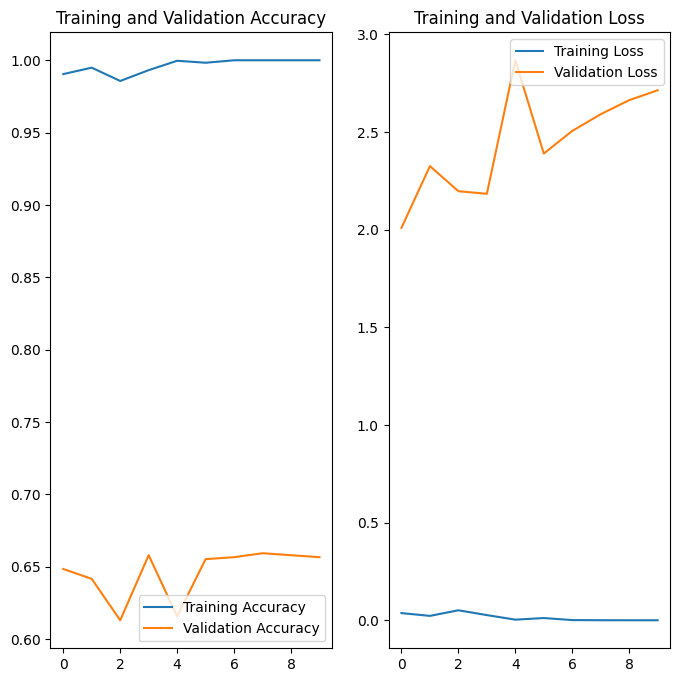

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Graferne viser, at træningsnøjagtighed og valideringsnøjagtighed afviger betydeligt, og modellen har kun opnået omkring 60% nøjagtighed på valideringssættet.

De følgende sektioner i vejledningen viser, hvordan du kan inspicere, hvad der gik galt, og forsøge at forbedre den samlede ydeevne af modellen.


## Overfitting

På graferne ovenfor stiger træningsnøjagtigheden lineært over tid, mens valideringsnøjagtigheden stagnerer omkring 60% i træningsprocessen. Derudover er forskellen i nøjagtighed mellem trænings- og valideringsnøjagtighed mærkbar - et tegn på [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Når der er et lille antal træningseksempler, lærer modellen sommetider fra støj eller uønskede detaljer i træningseksemplerne i en sådan grad, at det negativt påvirker modellens ydeevne på nye eksempler. Dette fænomen kaldes overfitting. Det betyder, at modellen vil have svært ved at generalisere på et nyt datasæt.

Der er flere måder at bekæmpe overfitting i træningsprocessen. I denne vejledning vil du bruge *dataaugmentering* og tilføje *dropout* til din model.


## Dataaugmentering
Overfitting opstår normalt, når der er et lille antal træningseksempler. [Dataaugmentering](./data_augmentation.ipynb) anvender tilgangen med at generere yderligere træningsdata fra dine eksisterende eksempler ved at udvide dem med tilfældige transformationer, der producerer troværdigt udseende billeder. Dette hjælper med at udsætte modellen for flere aspekter af dataen og generalisere bedre.

Du vil implementere dataaugmentering ved hjælp af følgende Keras-forbehandlingslag: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation` og `tf.keras.layers.RandomZoom`. Disse kan inkluderes i din model som andre lag og køre på GPU'en.


In [27]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualisér nogle augmenterede eksempler ved at anvende dataaugmentering til det samme billede flere gange:

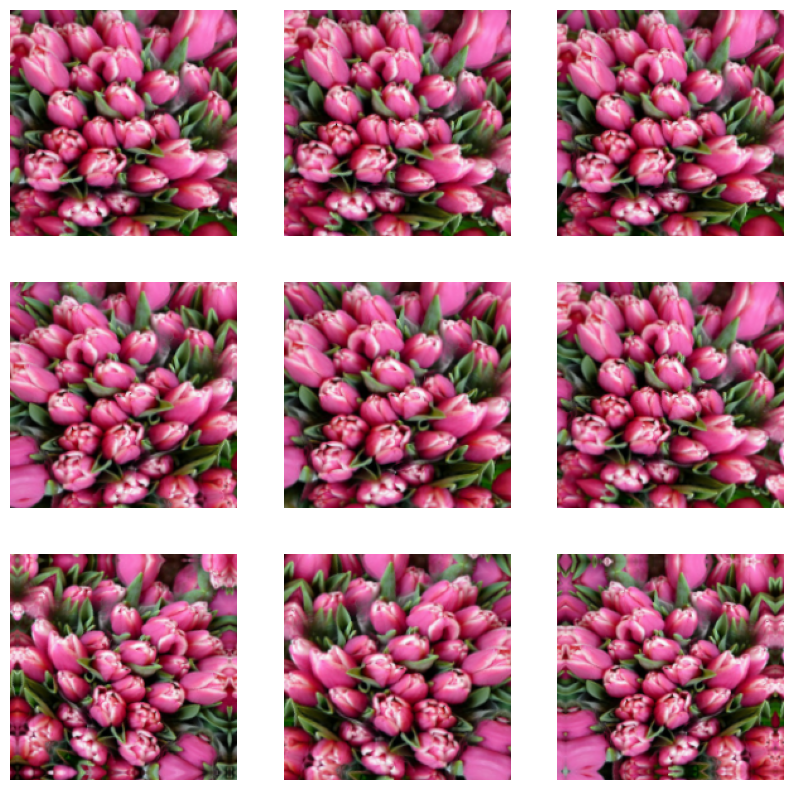

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Du vil tilføje dataaugmentering til din model inden træning i næste trin.

## Dropout

En anden teknik til at reducere overfitting er at introducere [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external}-regulering til netværket.

Når du anvender dropout på et lag, udelukker det tilfældigt (ved at indstille aktiveringen til nul) et antal outputenheder fra laget under træningsprocessen. Dropout tager et brøkdeligt tal som inputværdi, i form som f.eks. 0,1, 0,2, 0,4, osv. Dette betyder, at 10%, 20% eller 40% af outputenhederne tilfældigt udelukkes fra det anvendte lag.

Opret et nyt neuralt netværk med `tf.keras.layers.Dropout` inden træning med de augmenterede billeder:


In [29]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Kompiler og træn modellen

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [32]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 33s 345ms/step - loss: 1.2774 - accuracy: 0.4523 - val_loss: 1.0358 - val_accuracy: 0.5777
Epoch 2/15
92/92 [==============================] - 34s 365ms/step - loss: 1.0165 - accuracy: 0.5960 - val_loss: 1.0065 - val_accuracy: 0.6090
Epoch 3/15
92/92 [==============================] - 34s 364ms/step - loss: 0.9035 - accuracy: 0.6495 - val_loss: 0.9297 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 34s 366ms/step - loss: 0.8542 - accuracy: 0.6740 - val_loss: 0.8692 - val_accuracy: 0.6689
Epoch 5/15
92/92 [==============================] - 34s 366ms/step - loss: 0.7917 - accuracy: 0.6965 - val_loss: 0.8969 - val_accuracy: 0.6499
Epoch 6/15
92/92 [==============================] - 34s 368ms/step - loss: 0.7571 - accuracy: 0.7142 - val_loss: 0.8587 - val_accuracy: 0.6553
Epoch 7/15
92/92 [==============================] - 34s 369ms/step - loss: 0.7324 - accuracy: 0.7207 - val_loss: 0.8151 - val_accuracy: 0.6798

## Visualisér træningsresultater

Efter at have anvendt dataaugmentering og `tf.keras.layers.Dropout` er der mindre overfitting end før, og trænings- og valideringsnøjagtighed er tættere på hinanden:


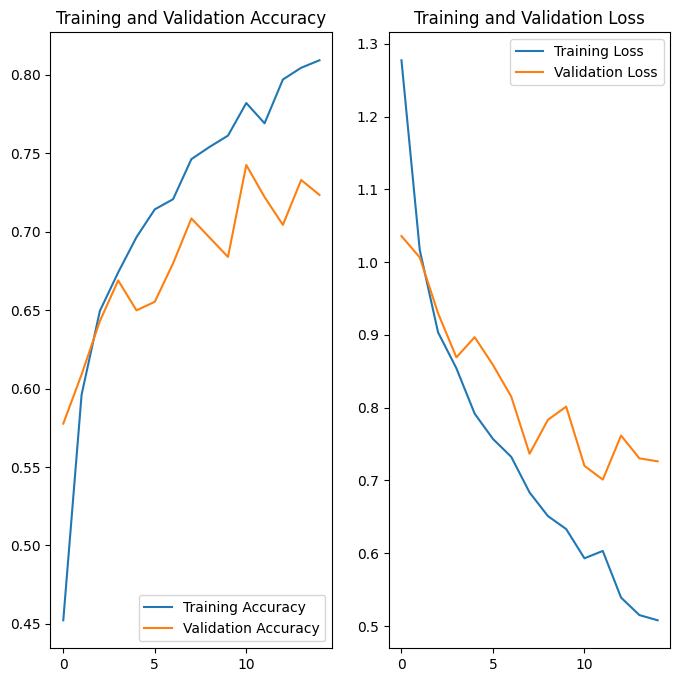

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Forudsige på ny data


Brug din model til at klassificere et billede, der ikke var inkluderet i trænings- eller valideringssættene.
Bemærk: Dataaugmentering og dropout-lag er inaktive under inferenstid.


In [34]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 167ms/step
This image most likely belongs to sunflowers with a 99.36 percent confidence.


## Brug TensorFlow Lite

TensorFlow Lite er et sæt af værktøjer, der muliggør maskinlæring på enheden ved at hjælpe udviklere med at køre deres modeller på mobile, indlejrede og kant-enheder.


### Konverter den Keras Sequential-model til en TensorFlow Lite-model

For at bruge den trænede model med on-device-applikationer skal du først [konvertere den](https://www.tensorflow.org/lite/models/convert) til en mindre og mere effektiv modelformat kaldet en [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

I dette eksempel tager du den trænede Keras Sequential-model og bruger `tf.lite.TFLiteConverter.from_keras_model` til at generere en [TensorFlow Lite](https://www.tensorflow.org/lite/) model:


In [35]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\KASPER~1.LAS\AppData\Local\Temp\tmpfyk4gjee\assets


INFO:tensorflow:Assets written to: C:\Users\KASPER~1.LAS\AppData\Local\Temp\tmpfyk4gjee\assets


Den TensorFlow Lite-model, du gemte i det forrige trin, kan indeholde flere funktionsunderskrifter. Keras modelkonverterings-API'en bruger automatisk den standardmæssige underskrift. Læs mere om [TensorFlow Lite-underskrifter](https://www.tensorflow.org/lite/guide/signatures).


### Kør TensorFlow Lite-modellen

Du kan få adgang til TensorFlow Lite gemte modelunderskrifter i Python via klassen `tf.lite.Interpreter`.

Indlæs modellen med `Interpreter`:


In [36]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Udskriv underskrifterne fra den konverterede model for at få navnene på input (og output):

In [37]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

I dette eksempel har du en standardunderskrift kaldet `serving_default`. Derudover er navnet på 'inputs' `'sequential_1_input'`, mens 'outputs' kaldes `'outputs'`. Du kan finde disse første og sidste Keras-lagnavne ved at køre `Model.summary`, som blev demonstreret tidligere i denne vejledning.

Nu kan du teste den indlæste TensorFlow-model ved at udføre inferens på et eksempelbillede med `tf.lite.Interpreter.get_signature_runner` ved at sende underskriftnavnet som følger:


In [38]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

På samme måde som du gjorde tidligere i vejledningen, kan du bruge TensorFlow Lite-modellen til at klassificere billeder, der ikke var inkluderet i trænings- eller valideringssættene.

Du har allerede tensoriseret det billede og gemt det som `img_array`. Nu skal du sende det som det første argument (navnet på 'inputs') til den indlæste TensorFlow Lite-model (`predictions_lite`), beregne softmax-aktivering og derefter udskrive forudsigelsen for klassen med den højeste beregnede sandsynlighed.


In [39]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [40]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 99.36 percent confidence.


Forudsigelsen genereret af den lette model bør være næsten identisk med forudsigelserne genereret af den originale model:


In [41]:
print(np.max(np.abs(predictions - predictions_lite)))

1.5497208e-06


Af de fem klasser - `'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'` og `'tulips'` - bør modellen forudsige, at billedet hører til solsikker, hvilket er det samme resultat som før konverteringen til TensorFlow Lite.


## Næste skridt

Denne vejledning viste, hvordan man træner en model til billedklassifikation, tester den, konverterer den til TensorFlow Lite-formatet til brug i on-device-applikationer (som f.eks. en billedklassifikationsapp) og udfører inferens med TensorFlow Lite-modellen ved hjælp af Python API'en.

Du kan lære mere om TensorFlow Lite gennem [vejledninger](https://www.tensorflow.org/lite/tutorials) og [guider](https://www.tensorflow.org/lite/guide).
